In [ ]:
#import libraries
import pandas as pd
import sqlite3
import missingno as msno
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay,confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
!pip install optuna
import optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read data
conn = sqlite3.connect('drive/MyDrive/database.sqlite')
match_df = pd.read_sql_query("SELECT * FROM Match", conn)
team_df = pd.read_sql_query("SELECT * FROM Team",conn)
team_attrb_df = pd.read_sql_query("SELECT * FROM Team_attributes", conn)

In [ ]:
team_df = team_df.merge(team_attrb_df , on = ['team_api_id','team_fifa_api_id'], how = 'left')
team_df['date'] = pd.to_datetime(team_df['date'])
team_df['year'] = team_df['date'].dt.year

In [ ]:
team_df=team_df[team_df['year']==2015]
match_df = match_df.merge(team_df, how='left', left_on='home_team_api_id', right_on='team_api_id')
match_df.rename(columns={'team_long_name': 'home_team_name'}, inplace=True)
match_df = match_df.merge(team_df, how='left', left_on='away_team_api_id', right_on='team_api_id')
match_df.rename(columns={'team_long_name': 'away_team_name'}, inplace=True)

In [ ]:
match_2016 = match_df[match_df['season'] == '2015/2016']

In [ ]:

match_2016['home_outcome'] = match_2016.apply(lambda x: 0 if x['away_team_goal'] > x['home_team_goal'] else (
            1 if x['home_team_goal'] > x['away_team_goal'] else 2), axis=1)
match_2016['winning_team_name'] =  match_2016.apply(lambda x: x['home_team_name'] if x['home_outcome']==1 else (
            x['away_team_name'] if x['home_outcome']==0 else None), axis=1)

In [ ]:
wins_16 = match_2016.winning_team_name.value_counts().head(10)
lose_16 = match_2016.winning_team_name.value_counts().tail(10)
wins_16 = wins_16.reset_index()
lose_16 = lose_16.reset_index()
wins_16.columns = ['team_name', 'wins']
lose_16.columns = ['team_name', 'wins']
top_teams = team_df[(team_df["team_long_name"].isin(wins_16['team_name'])) & (team_df['year'] == 2015)]
worst_teams = team_df[(team_df["team_long_name"].isin(lose_16['team_name'])) & (team_df['year'] == 2015)]
top_teams=top_teams.merge(wins_16,left_on="team_long_name",right_on="team_name",how="inner").sort_values(by=['wins'])
worst_teams=worst_teams.merge(lose_16,left_on="team_long_name",right_on="team_name",how="inner").sort_values(by=['wins'],ascending=False)

In [ ]:
numerical_attributes = ['team_long_name', 'buildUpPlaySpeed', 'buildUpPlayPassing','chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting','defencePressure', 'defenceAggression', 'defenceTeamWidth']

<ipython-input-12-e43fc36b3037>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')


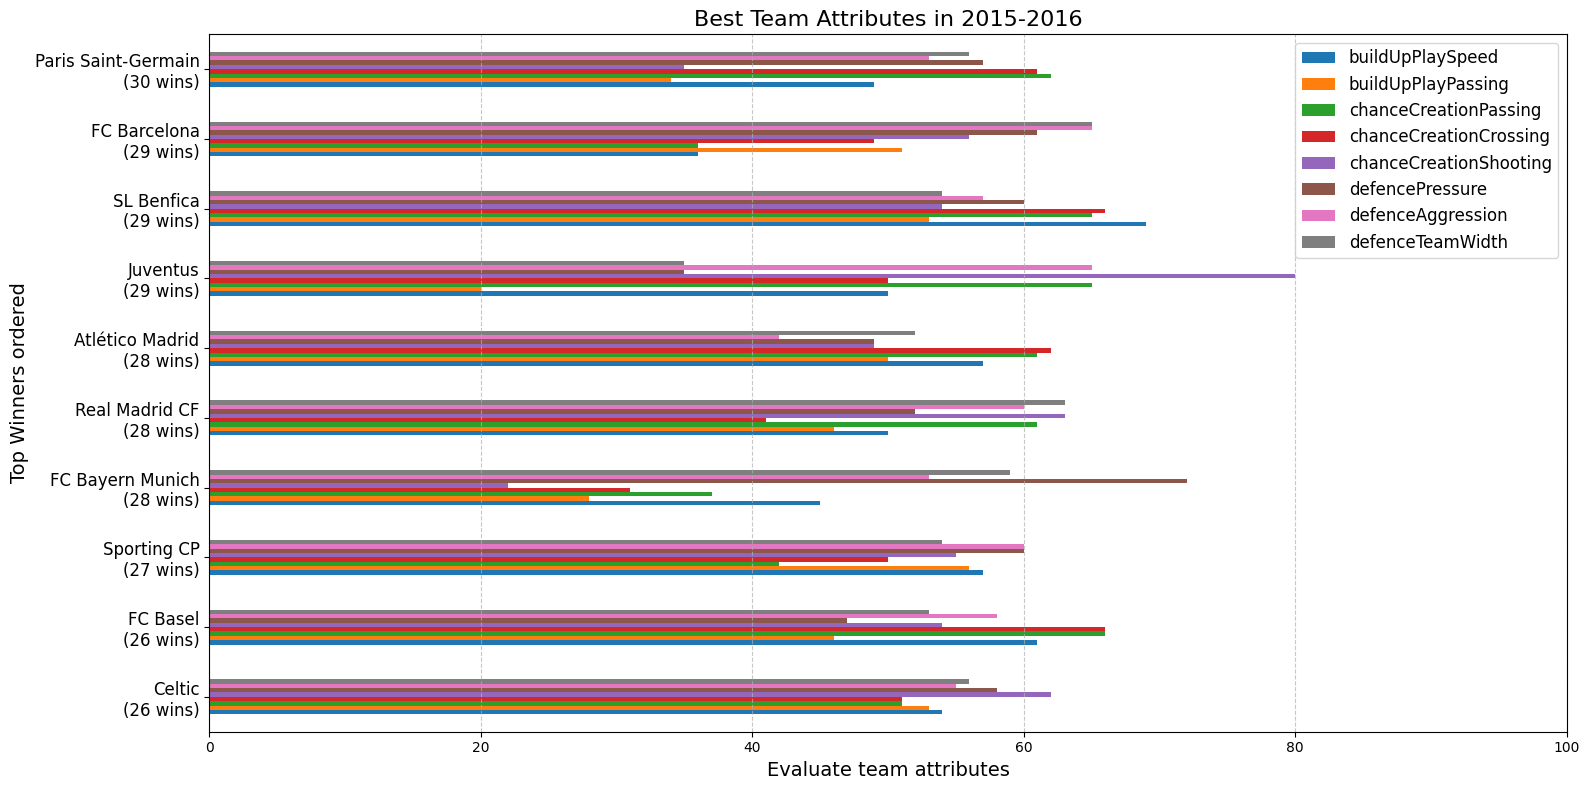

In [ ]:

# Set the style
plt.style.use('seaborn-muted')

fig, ax = plt.subplots(figsize=(16, 8))

# Create a new bar chart with custom colors
colors = plt.cm.tab10.colors[:len(top_teams)]
bar_plot = top_teams[numerical_attributes].plot.barh(ax=ax, color=colors)

# Set the y tick labels with number of wins under the team name
ytick_labels = [f"{team}\n({wins} wins)" for team, wins in zip(top_teams['team_long_name'], top_teams['wins'])]
ax.set_yticklabels(ytick_labels, fontsize=12)

# Set the y axis label
ax.set_ylabel('Top Winners ordered', fontsize=14)

# Set the chart's title
ax.set_title('Best Team Attributes in 2015-2016', fontsize=16)

# Set the x axis label
ax.set_xlabel("Evaluate team attributes", fontsize=14)

# Set x-axis limits
ax.set_xlim(0, 100)

# Add grid lines
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Add legend
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()


<ipython-input-13-760fc359ca90>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')


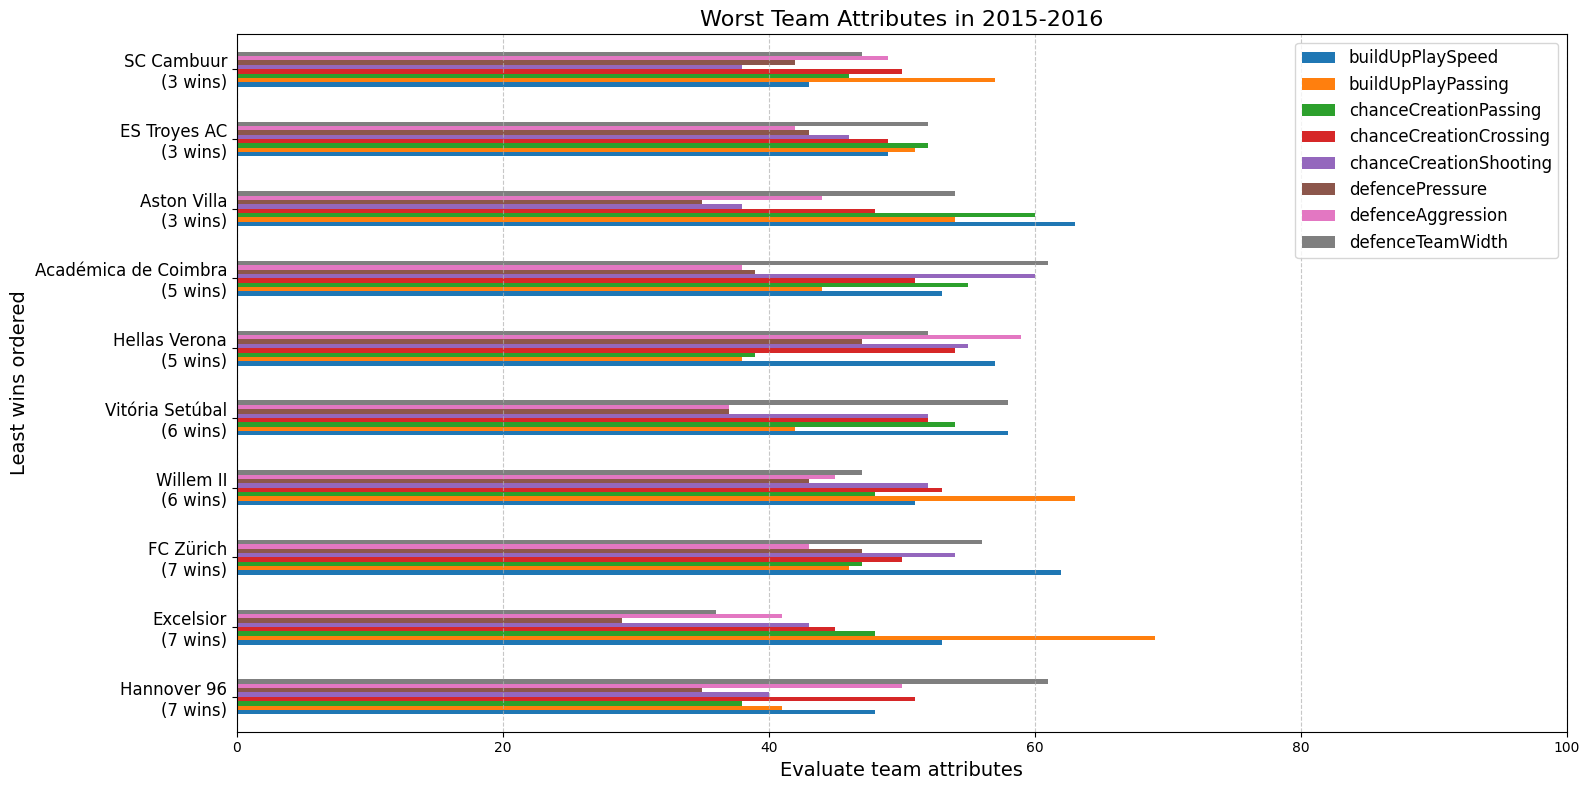

In [ ]:

# Set the style
plt.style.use('seaborn-muted')

fig, ax = plt.subplots(figsize=(16, 8))

# Create a new bar chart with custom colors
colors = plt.cm.tab10.colors[:len(worst_teams)]
bar_plot = worst_teams[numerical_attributes].plot.barh(ax=ax, color=colors)

# Set the y tick labels with number of wins under the team name
ytick_labels = [f"{team}\n({wins} wins)" for team, wins in zip(worst_teams['team_long_name'], worst_teams['wins'])]
ax.set_yticklabels(ytick_labels, fontsize=12)

# Set the y axis label
ax.set_ylabel('Least wins ordered', fontsize=14)

# Set the chart's title
ax.set_title('Worst Team Attributes in 2015-2016', fontsize=16)

# Set the x axis label
ax.set_xlabel("Evaluate team attributes", fontsize=14)

# Set x-axis limits
ax.set_xlim(0, 100)

# Add grid lines
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Add legend
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
match_df=pd.read_sql_query("SELECT * FROM Match", conn)
match_df.dtypes

id              int64
country_id      int64
league_id       int64
season         object
stage           int64
               ...   
GBD           float64
GBA           float64
BSH           float64
BSD           float64
BSA           float64
Length: 115, dtype: object

In [ ]:
team_attrb_df.dtypes

id                                  int64
team_fifa_api_id                    int64
team_api_id                         int64
date                               object
buildUpPlaySpeed                    int64
buildUpPlaySpeedClass              object
buildUpPlayDribbling              float64
buildUpPlayDribblingClass          object
buildUpPlayPassing                  int64
buildUpPlayPassingClass            object
buildUpPlayPositioningClass        object
chanceCreationPassing               int64
chanceCreationPassingClass         object
chanceCreationCrossing              int64
chanceCreationCrossingClass        object
chanceCreationShooting              int64
chanceCreationShootingClass        object
chanceCreationPositioningClass     object
defencePressure                     int64
defencePressureClass               object
defenceAggression                   int64
defenceAggressionClass             object
defenceTeamWidth                    int64
defenceTeamWidthClass             

In [ ]:
cols_to_drop = ['id','country_id','league_id','season', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession','goal']
match_df.drop(columns=cols_to_drop, axis=1, inplace=True)
match_df.drop(list(match_df.filter(regex='player')), axis=1, inplace=True)
match_df.drop(list(match_df.filter(regex='^[A-Z0-9]+$')),axis=1, inplace=True)

In [ ]:
print('Number of null values:',match_df.isna().sum().sum())
print('Number of duplicated rows:',match_df.duplicated().sum())

Number of null values: 0
Number of duplicated rows: 0


In [ ]:
team_attrb_df.drop(columns=['id','team_fifa_api_id'], axis=1, inplace=True)

In [ ]:
print(team_attrb_df.isna().sum())
print()
print('Number of null values:',team_attrb_df.isna().sum().sum())
print('Number of duplicated rows:',team_attrb_df.duplicated().sum())

team_api_id                         0
date                                0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
dtype: int64

Number of null values: 969
Number of duplicated rows: 1


In [ ]:
print(team_attrb_df['buildUpPlayDribbling'].isna().sum() / len(team_attrb_df['buildUpPlayDribbling']))

0.6646090534979424


<Axes: >

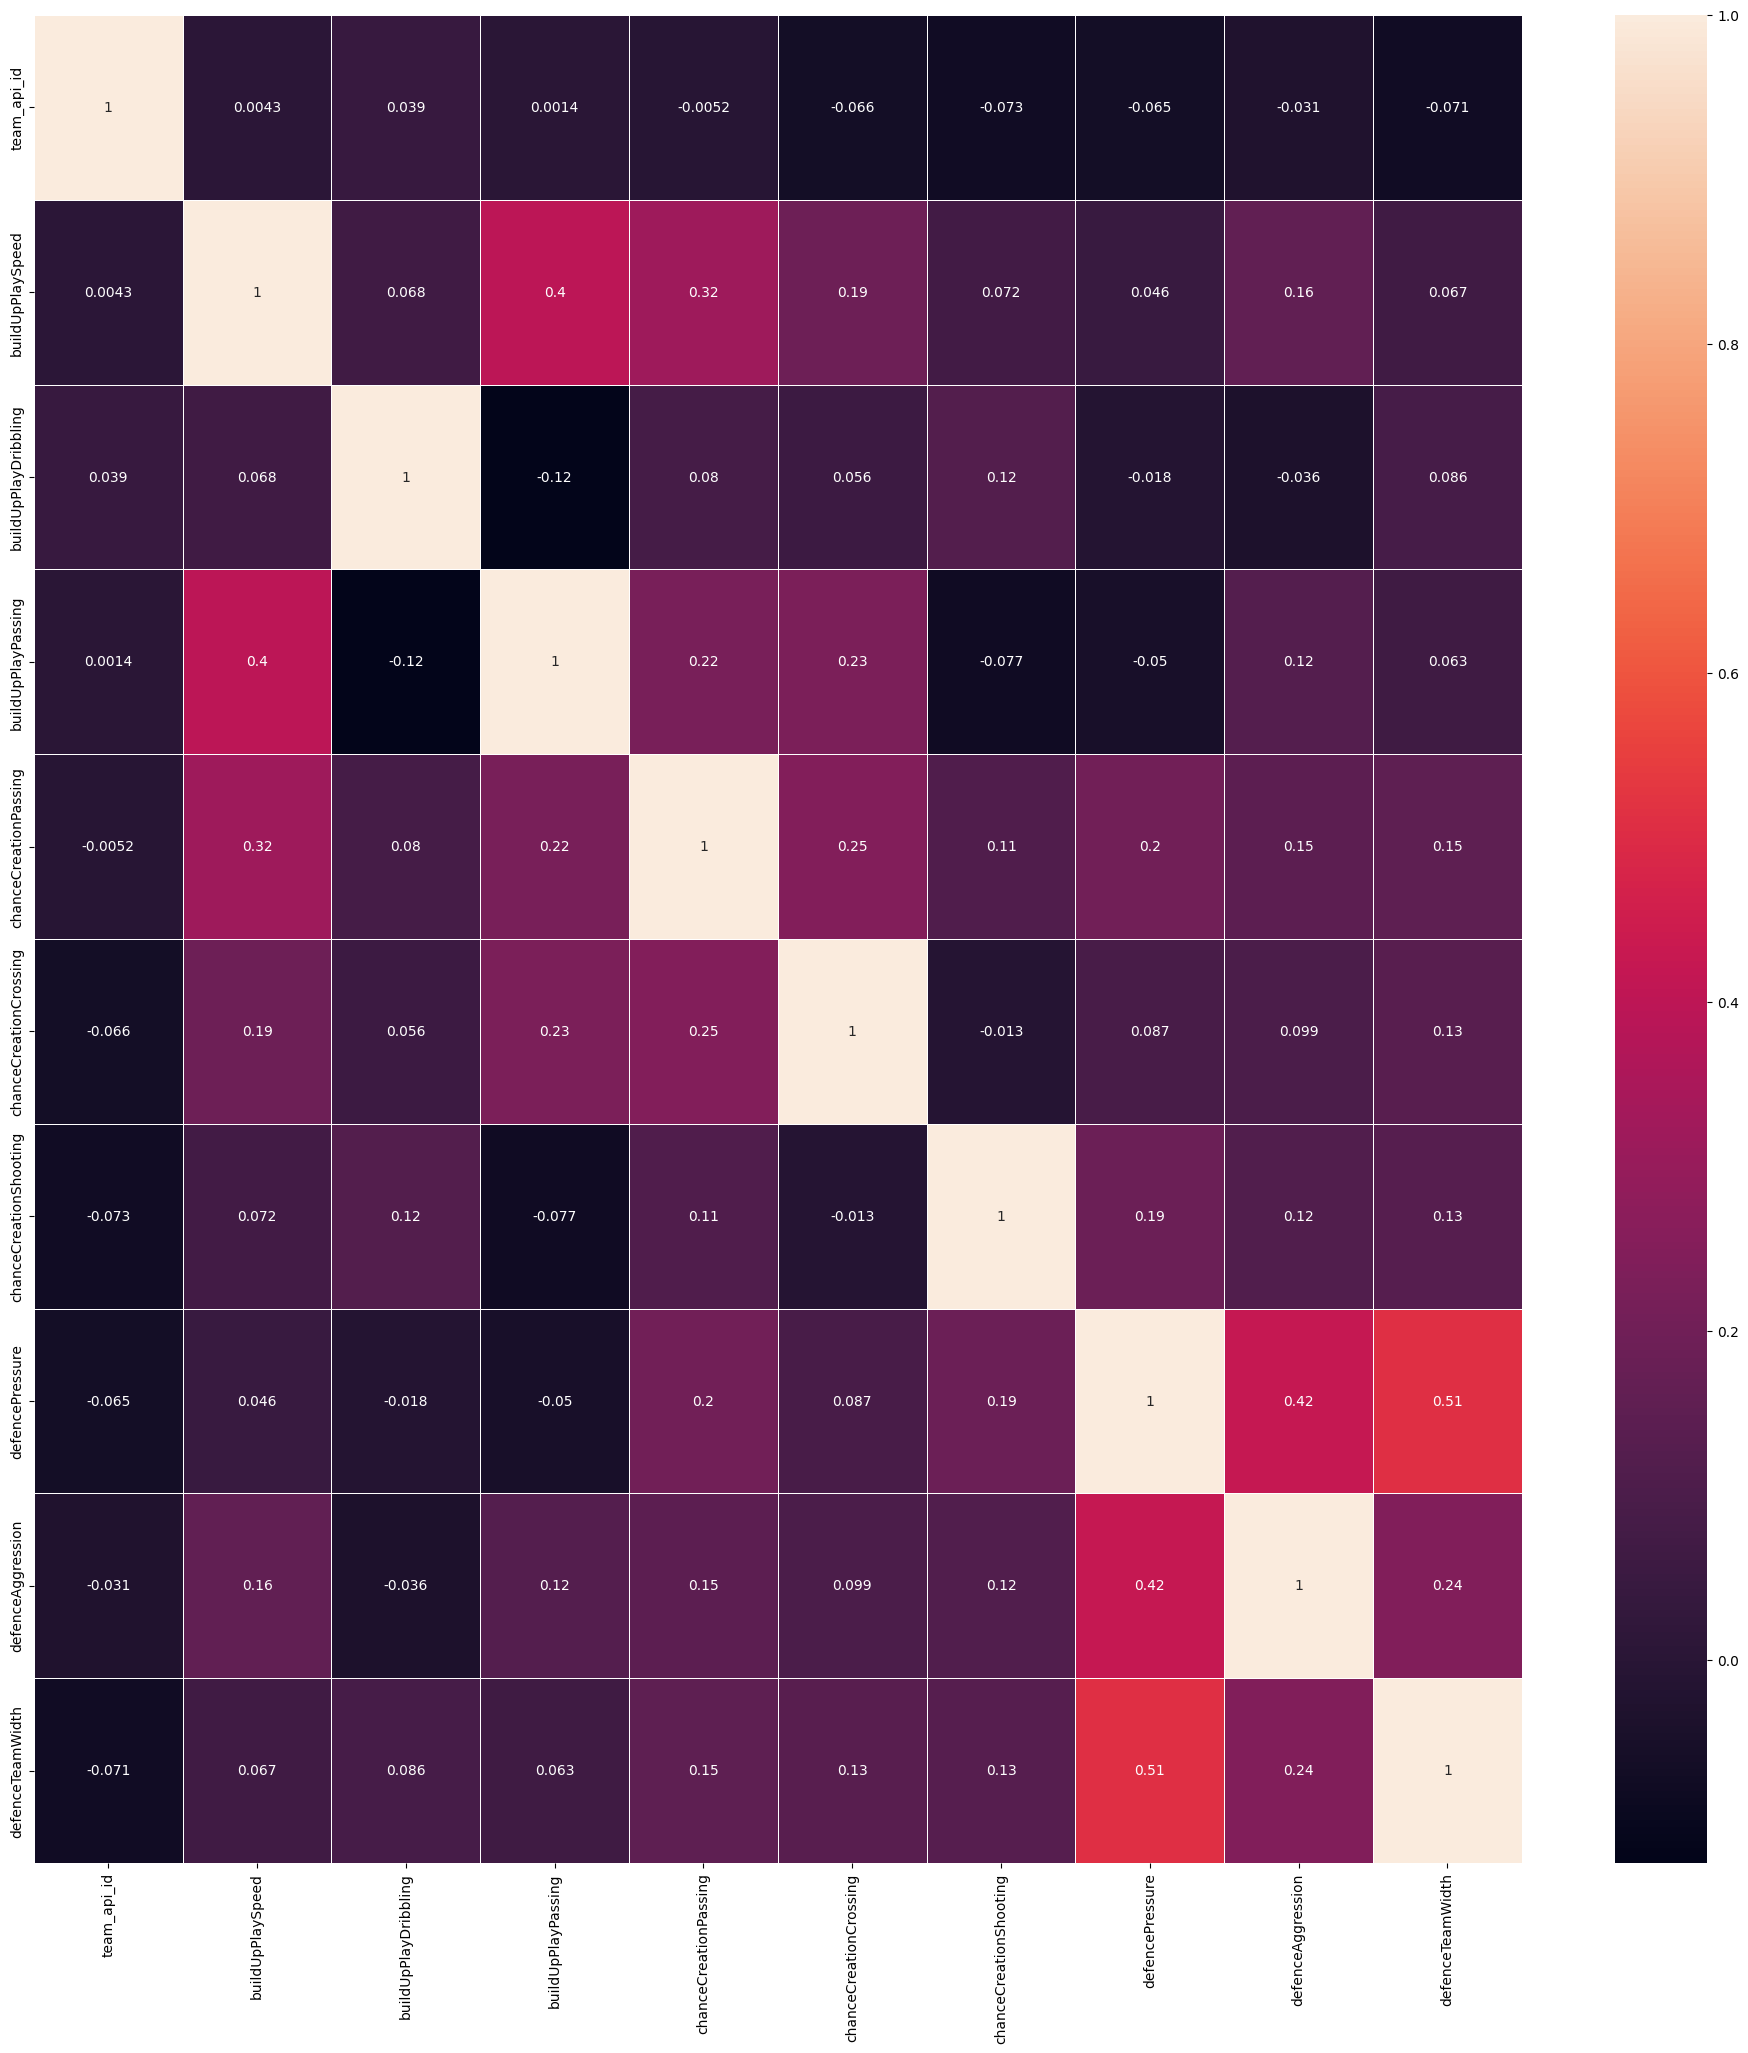

In [ ]:
corr2=team_attrb_df.corr(numeric_only=True)
fig2,ax2 = plt.subplots(nrows = 1,ncols = 1)
fig2.set_size_inches(w=24,h=24)
sns.heatmap(corr2,annot = True,linewidths=0.5,ax = ax2)

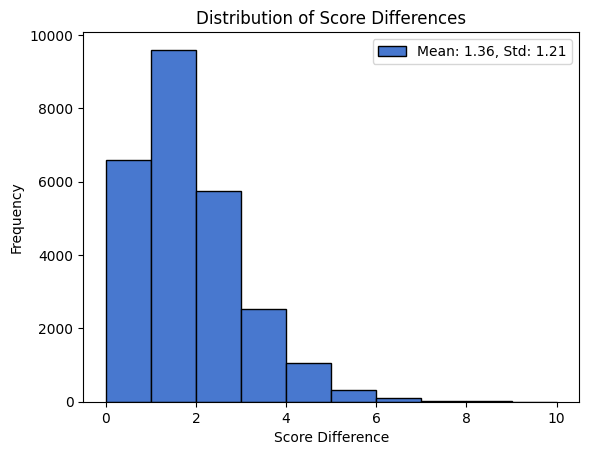

In [ ]:
score_diffs = (match_df['home_team_goal'] - match_df['away_team_goal']).abs()

plt.hist(score_diffs, bins=range(score_diffs.min(), score_diffs.max()+1), edgecolor='black')
plt.xlabel('Score Difference')
plt.ylabel('Frequency')
plt.title('Distribution of Score Differences')

# Calcul de la moyenne et de l'écart type
mean_diff = score_diffs.mean()
std_diff = score_diffs.std()

# Ajout de la légende
plt.legend([f'Mean: {mean_diff:.2f}, Std: {std_diff:.2f}'], loc='best')

plt.show()

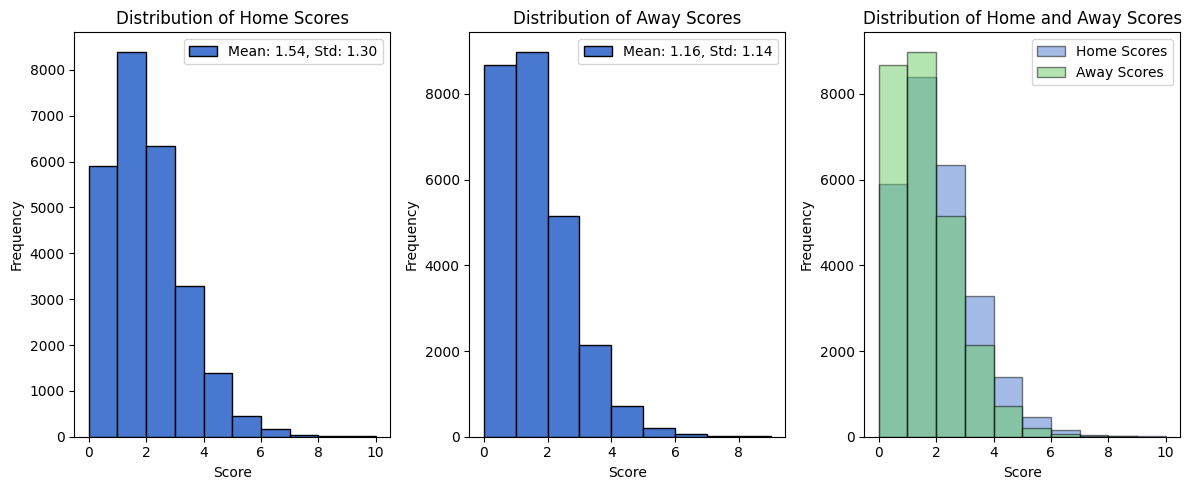

In [ ]:
# Création de la figure et des sous-graphiques
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# Plot pour les scores à domicile
score_diffs_home = match_df['home_team_goal']
axs[0].hist(score_diffs_home, bins=range(score_diffs_home.min(), score_diffs_home.max()+1), edgecolor='black')
axs[0].set_xlabel('Score')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Home Scores')

# Calcul de la moyenne et de l'écart type pour les scores à domicile
mean_diff_home = score_diffs_home.mean()
std_diff_home = score_diffs_home.std()

# Ajout de la légende pour les scores à domicile
axs[0].legend([f'Mean: {mean_diff_home:.2f}, Std: {std_diff_home:.2f}'], loc='best')

# Plot pour les scores à l'extérieur
score_diffs_away = match_df['away_team_goal']
axs[1].hist(score_diffs_away, bins=range(score_diffs_away.min(), score_diffs_away.max()+1), edgecolor='black')
axs[1].set_xlabel('Score')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Away Scores')

# Calcul de la moyenne et de l'écart type pour les scores à l'extérieur
mean_diff_away = score_diffs_away.mean()
std_diff_away = score_diffs_away.std()

# Ajout de la légende pour les scores à l'extérieur
axs[1].legend([f'Mean: {mean_diff_away:.2f}, Std: {std_diff_away:.2f}'], loc='best')

# Plotting overlayed histograms
axs[2].hist(score_diffs_home, bins=range(score_diffs_home.min(), score_diffs_home.max()+1), alpha=0.5, label='Home Scores', edgecolor='black')
axs[2].hist(score_diffs_away, bins=range(score_diffs_away.min(), score_diffs_away.max()+1), alpha=0.5, label='Away Scores', edgecolor='black')
axs[2].set_xlabel('Score')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Distribution of Home and Away Scores')

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
team_attrb_df.drop(columns=['buildUpPlayDribbling'], axis=1, inplace=True)
match_df['year'] = pd.to_datetime(match_df['date']).dt.year
team_attrb_df['year'] = pd.to_datetime(team_attrb_df['date']).dt.year

In [ ]:
#Merge home team attributes with match data
merged_home = pd.merge(team_attrb_df, match_df, left_on=['team_api_id','year'], right_on=['home_team_api_id','year'], how="right")

In [ ]:
#Find matches where home team attributes are missing
year_match_home = merged_home[merged_home.isna().any(axis=1)][['year', 'home_team_api_id','match_api_id']]

In [ ]:
#Merge missing home team attributes with team attributes
merged_data_home = pd.merge(year_match_home, team_attrb_df[['team_api_id', 'year']], left_on='home_team_api_id', right_on='team_api_id', how='inner')

In [ ]:
#Calculate the year distance between match and team attributes, find closest year matches
merged_data_home['year_distance'] = abs(merged_data_home['year_x'] - merged_data_home['year_y'])
closest_year_home_index = merged_data_home.groupby('match_api_id')['year_distance'].idxmin()
closest_years_home = merged_data_home.loc[closest_year_home_index, ['match_api_id', 'year_y']]

In [ ]:
#Merge closest year matches with match data
temp_home = pd.merge(closest_years_home, merged_home, left_on='match_api_id', right_on='match_api_id', how='inner')
temp_home.dropna(axis=1, how='all', inplace=True)
temp_home = pd.merge(temp_home, team_attrb_df, left_on=['home_team_api_id','year_y'], right_on=['team_api_id','year'], how='inner')
temp_home.drop(list(temp_home.filter(regex='date')), axis=1, inplace=True)
merged_home.drop(list(merged_home.filter(regex='date')), axis=1, inplace=True)
merged_home.dropna(axis=0, how='any', inplace=True)
temp_home.drop(columns='year_y', axis=1, inplace=True)
temp_home.rename(columns={'year_x': 'year'}, inplace=True)

In [ ]:
#Concatenate processed home team data with merged data
merged_df = pd.concat([temp_home, merged_home])

In [ ]:
merged_df = pd.merge(team_attrb_df, merged_df, left_on=['team_api_id','year'], right_on=['away_team_api_id','year'], how="right")

In [ ]:
year_match_away = merged_df[merged_df.isna().any(axis=1)][['year', 'away_team_api_id','match_api_id']]

In [ ]:
merged_data_away = pd.merge(year_match_away, team_attrb_df[['team_api_id', 'year']], left_on='away_team_api_id', right_on='team_api_id', how='inner')

In [ ]:
merged_data_away['year_distance'] = abs(merged_data_away['year_x'] - merged_data_away['year_y'])
closest_year_away_index = merged_data_away.groupby('match_api_id')['year_distance'].idxmin()
closest_years_away = merged_data_away.loc[closest_year_away_index, ['match_api_id', 'year_y']]

In [ ]:
temp_away = pd.merge(closest_years_away, merged_df, left_on='match_api_id', right_on='match_api_id', how='inner')
temp_away.dropna(axis=1, how='all', inplace=True)
team_attrb_away_df = team_attrb_df.add_suffix('_x')
temp_away = pd.merge(temp_away, team_attrb_away_df, left_on=['away_team_api_id','year_y'], right_on=['team_api_id_x','year_x'], how='inner')
temp_away.drop(list(temp_away.filter(regex='date')), axis=1, inplace=True)
merged_df.drop(list(merged_df.filter(regex='date')), axis=1, inplace=True)
temp_away.drop(list(temp_away.filter(regex='year')), axis=1, inplace=True)
merged_df.drop(list(merged_df.filter(regex='year')), axis=1, inplace=True)
merged_df.dropna(axis=0, how='any', inplace=True)

In [ ]:
merged_df = pd.concat([temp_away, merged_df])

In [ ]:
# Drop id and date columns
merged_df.drop(list(merged_df.filter(regex='id')), axis=1, inplace=True)

In [ ]:
# Normalize data
merged_df_num = merged_df.select_dtypes(include='number')
merged_df_norm = (merged_df_num - merged_df_num.min()) / (merged_df_num.max() - merged_df_num.min())
merged_df[merged_df_norm.columns] = merged_df_norm

In [ ]:
# Create a new column for match outcome and drop goal-related columns
merged_df['home_outcome'] = merged_df.apply(lambda x: 0 if x['away_team_goal'] > x['home_team_goal'] else (
            1 if x['home_team_goal'] > x['away_team_goal'] else 2), axis=1)
merged_df.drop(list(merged_df.filter(regex='goal')), axis=1, inplace=True)

In [ ]:
# encode all categorical data
cols_to_encode = merged_df.select_dtypes(include=['object']).columns
merged_df[cols_to_encode] = merged_df[cols_to_encode].apply(LabelEncoder().fit_transform)

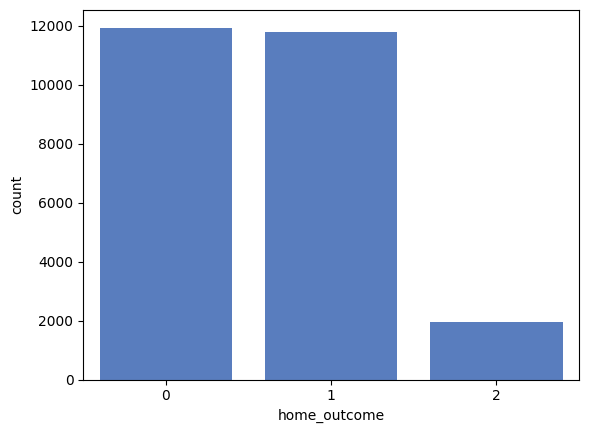

In [ ]:
sns.countplot(x='home_outcome', data=pd.DataFrame(merged_df['home_outcome']))
plt.show()

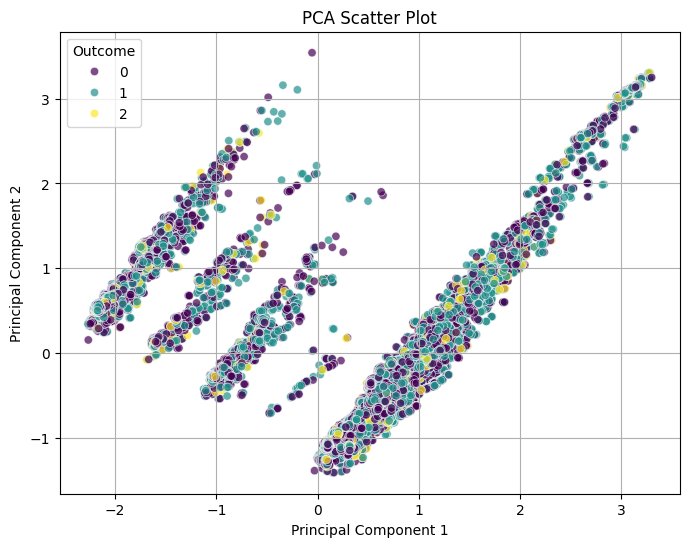

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(merged_df.drop('home_outcome', axis=1))

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=merged_df.index)

# Concatenate PCA results with outcome
pca_df = pd.concat([pca_df, merged_df['home_outcome']], axis=1)

# Plot PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='home_outcome', palette='viridis', alpha=0.7)

# Set labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')

plt.grid(True)
plt.legend(title='Outcome')
plt.show()

In [ ]:
y = merged_df['home_outcome']
x = merged_df.drop('home_outcome', axis=1)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
#smt = SMOTE(random_state=42)
#x_smote, y_smote = smt.fit_resample(x_train,y_train)
# Initialize the Random Forest classifier


In [ ]:
model_results_df=pd.DataFrame(columns=["precision","recall","f1","model_name"])

In [ ]:
scores =[]
for k in range(1, 100,5):
    rfc = RandomForestClassifier(n_estimators=k)
    rfc.fit(x_train, y_train)
    y_pred = rfc.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))

# plot the relationship between K and testing accuracy
plt.plot(range(1, 100 ,5), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Testing Accuracy')

In [ ]:
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

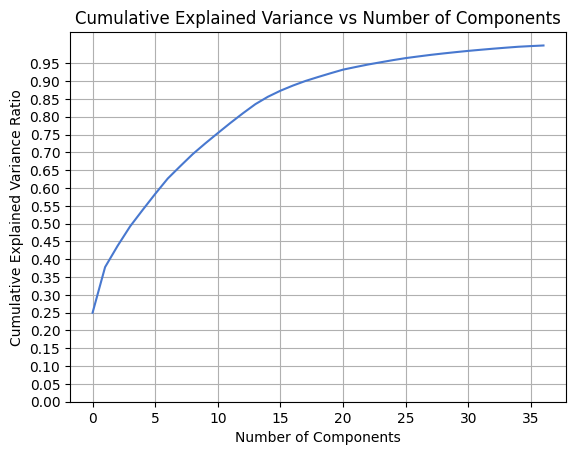

In [ ]:
# Plot the cumulative explained variance ratio
plt.plot(cumsum)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.grid(True)
plt.yticks(np.arange(0, 1, 0.05))
plt.show()

In [ ]:
# Number of dimensions to reduce to
k = 25

# Create a PCA object
pca = PCA(n_components=k,random_state=42)

# Fit the PCA model and transform the data
x_pca = pca.fit_transform(x)

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_pca)
x_train_pca, x_test_pca, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [8,10,12,14,16,18,20],
    'max_features': ['sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
CV_rfc = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv= 5)

In [ ]:
CV_rfc.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [8, 10, 12, 14, 16, 18, 20]})

In [ ]:
CV_rfc.best_params_

{'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 20}

In [ ]:
def addReportDf(model_results_df,report,model_name):
  row=[report['weighted avg']['precision'], report['weighted avg']['recall'],report['weighted avg']['f1-score'],model_name]
  model_results_df.loc[len(model_results_df)] = row
  return model_results_df

In [ ]:
#Calculate the frequency of each class
class_frequency = merged_df['home_outcome'].value_counts(normalize=True)

# Assign a probability for each class
class_probs = class_frequency.values
class_labels = class_frequency.index

# Generate random numbers
num_samples = len(merged_df)
random_numbers = np.random.rand(num_samples)

# Assign classes based on probabilities
predicted_classes = np.random.choice(class_labels, size=num_samples, p=class_probs)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(merged_df['home_outcome'], predicted_classes)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(merged_df['home_outcome'], predicted_classes,output_dict=True)
print("Classification Report:")
print(report)
model_results_df=addReportDf(model_results_df,report,"Random")

Accuracy: 0.4258934486924666
Classification Report:
{'0': {'precision': 0.4587567750677507, 'recall': 0.45406538139145014, 'f1-score': 0.4563990226640829, 'support': 11930}, '1': {'precision': 0.45131180625630674, 'recall': 0.4558348904365551, 'f1-score': 0.45356207217104705, 'support': 11774}, '2': {'precision': 0.07350689127105667, 'recall': 0.07365728900255754, 'f1-score': 0.07358201328564128, 'support': 1955}, 'accuracy': 0.4258934486924666, 'macro avg': {'precision': 0.32785849086503804, 'recall': 0.32785252027685424, 'f1-score': 0.32784770270692376, 'support': 25659}, 'weighted avg': {'precision': 0.42598774332027506, 'recall': 0.4258934486924666, 'f1-score': 0.42592981075247843, 'support': 25659}}


In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=20,max_features='log2',criterion='gini',random_state=42)
# Train the classifier on the training data
rf_classifier.fit(x_train, y_train)
# Make predictions on the test data
y_pred = rf_classifier.predict(x_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred,output_dict=True)
print("Accuracy test:", accuracy)
print("Classification report", report)
model_results_df=addReportDf(model_results_df,report,"Random Forest")

Accuracy test: 0.5204598597038191
Classification report {'0': {'precision': 0.5169939577039275, 'recall': 0.5873015873015873, 'f1-score': 0.549909620405704, 'support': 2331}, '1': {'precision': 0.5542685542685543, 'recall': 0.5363221253632212, 'f1-score': 0.5451476793248945, 'support': 2409}, '2': {'precision': 0.06535947712418301, 'recall': 0.025510204081632654, 'f1-score': 0.03669724770642202, 'support': 392}, 'accuracy': 0.5204598597038191, 'macro avg': {'precision': 0.3788739963655549, 'recall': 0.3830446389154804, 'f1-score': 0.3772515158123402, 'support': 5132}, 'weighted avg': {'precision': 0.4999935264367658, 'recall': 0.5204598597038191, 'f1-score': 0.5084733838192292, 'support': 5132}}


In [ ]:
CV_rfc.fit(x_train_pca, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [8, 10, 12, 14, 16, 18, 20]})

In [ ]:
CV_rfc.best_params_

{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 20}

In [ ]:
rf_classifier_pca = RandomForestClassifier(n_estimators=20,max_features='log2',criterion='entropy',random_state=42)
rf_classifier_pca.fit(x_train_pca, y_train)
y_pred = rf_classifier_pca.predict(x_test_pca)
pca_accuracy = accuracy_score(y_test, y_pred)
pca_report = classification_report(y_test, y_pred,output_dict=True)
print("Accuracy test:", pca_accuracy)
print("Classification report", pca_report)
model_results_df=addReportDf(model_results_df,report,"PCA Random Forest")

Accuracy test: 0.5116913484021823
Classification report {'0': {'precision': 0.5067014147431125, 'recall': 0.5838695838695839, 'f1-score': 0.542555311939406, 'support': 2331}, '1': {'precision': 0.5422049956933678, 'recall': 0.522623495226235, 'f1-score': 0.5322341999577257, 'support': 2409}, '2': {'precision': 0.04838709677419355, 'recall': 0.015306122448979591, 'f1-score': 0.02325581395348837, 'support': 392}, 'accuracy': 0.5116913484021823, 'macro avg': {'precision': 0.3657645024035579, 'recall': 0.37393306718159947, 'f1-score': 0.3660151086168734, 'support': 5132}, 'weighted avg': {'precision': 0.4883594260185118, 'recall': 0.5116913484021823, 'f1-score': 0.49804460227955655, 'support': 5132}}


In [ ]:
sample_weights = np.zeros(len(y_train))
sample_weights[y_train == 0] = 1.0
sample_weights[y_train == 1] = 1.0
sample_weights[y_train == 2] = 3.0

In [ ]:
def objective(trial):
    # Define the search space for hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 5000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9, step=0.1),
        "max_features": trial.suggest_categorical(
            "max_features", ["sqrt", "log2"]
        ),
        "random_state": 42,
        "n_iter_no_change": 50,  # early stopping
        "validation_fraction": 0.05,
    }

    # Initialize the Gradient Boosting model with early stopping
    gb_model = GradientBoostingClassifier(**params)

    # Fit the model to the training data
    gb_model.fit(x_train_pca, y_train)

    # Make predictions on the test set
    y_pred = gb_model.predict(x_test_pca)

    # Calculate accuracy as the objective to be minimized
    accuracy = accuracy_score(y_test, y_pred)

    return 1.0 - accuracy  # Optuna minimizes the objective, so we use 1 - accuracy

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

# Get the best parameters and best model
best_params_optuna = study.best_params
best_model_optuna = GradientBoostingClassifier(**best_params_optuna, validation_fraction=0.1, n_iter_no_change=5, random_state=42)
best_model_optuna.fit(x_train, y_train)

[I 2024-04-28 05:52:24,473] A new study created in memory with name: no-name-8952c076-980a-46d2-983c-42f71c55c34f
[I 2024-04-28 05:52:38,779] Trial 0 finished with value: 0.4429072486360094 and parameters: {'n_estimators': 3200, 'learning_rate': 0.18406311678991572, 'max_depth': 3, 'subsample': 0.9, 'max_features': 'log2'}. Best is trial 0 with value: 0.4429072486360094.
[I 2024-04-28 05:53:50,181] Trial 1 finished with value: 0.4547934528448948 and parameters: {'n_estimators': 4300, 'learning_rate': 0.0048392598600873185, 'max_depth': 3, 'subsample': 0.6, 'max_features': 'log2'}. Best is trial 0 with value: 0.4429072486360094.
[I 2024-04-28 05:57:09,371] Trial 2 finished with value: 0.4524551831644583 and parameters: {'n_estimators': 3400, 'learning_rate': 0.0007533677382998914, 'max_depth': 4, 'subsample': 0.7, 'max_features': 'log2'}. Best is trial 0 with value: 0.4429072486360094.
[I 2024-04-28 05:57:14,542] Trial 3 finished with value: 0.4438815276695246 and parameters: {'n_estima

In [ ]:
y_pred_best_optuna = best_model_optuna.predict(x_test)

# Evaluate the best model obtained through Optuna
accuracy_best_optuna = accuracy_score(y_test, y_pred_best_optuna)
report = classification_report(y_test, y_pred_best_optuna)
print(f"Best Model Accuracy (Optuna): {accuracy_best_optuna}")
print("Classification report", report)

Best Model Accuracy (Optuna): 0.5434528448947779
Classification report               precision    recall  f1-score   support

           0       0.53      0.62      0.57      2331
           1       0.56      0.55      0.56      2409
           2       0.00      0.00      0.00       392

    accuracy                           0.54      5132
   macro avg       0.36      0.39      0.38      5132
weighted avg       0.50      0.54      0.52      5132



In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

# Get the best parameters and best model
best_params_optuna = study.best_params
best_model_optuna = GradientBoostingClassifier(**best_params_optuna, validation_fraction=0.1, n_iter_no_change=5, random_state=42)
best_model_optuna.fit(x_train_pca, y_train)

In [ ]:
gb=GradientBoostingClassifier(learning_rate=0.1380535422532766, max_depth=5,
                           max_features='log2', n_estimators=4700,
                           n_iter_no_change=5, random_state=42, subsample=0.9).fit(x_train,y_train)
y_pred_best_optuna = gb.predict(x_test)

# Evaluate the best model obtained through Optuna
accuracy_best_optuna = accuracy_score(y_test, y_pred_best_optuna)
report = classification_report(y_test, y_pred_best_optuna, output_dict=True)
print(f"Best Model Accuracy (Optuna): {accuracy_best_optuna}")
print("Classification report", report)
#model_results_df=addReportDf(model_results_df,report, "GradientBoostingClassifier")

Best Model Accuracy (Optuna): 0.5547544816835541
Classification report {'0': {'precision': 0.5373134328358209, 'recall': 0.6332046332046332, 'f1-score': 0.5813312327688066, 'support': 2331}, '1': {'precision': 0.5756302521008403, 'recall': 0.568700705687007, 'f1-score': 0.5721444978074754, 'support': 2409}, '2': {'precision': 0.2, 'recall': 0.002551020408163265, 'f1-score': 0.0050377833753148605, 'support': 392}, 'accuracy': 0.5547544816835541, 'macro avg': {'precision': 0.43764789497888706, 'recall': 0.4014854530999345, 'f1-score': 0.3861711713171989, 'support': 5132}, 'weighted avg': {'precision': 0.529534467897744, 'recall': 0.5547544816835541, 'f1-score': 0.5329996122146181, 'support': 5132}}


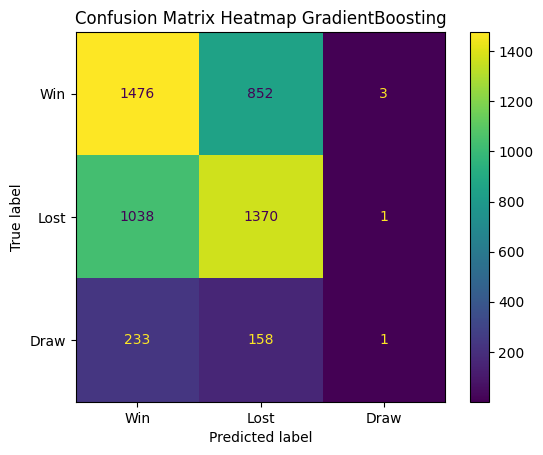

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_best_optuna, labels=gb.classes_)

# Rename the labels
display_labels = ['Win', 'Lost', 'Draw']

# Plot the confusion matrix heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap='viridis')

# Add title
plt.title('Confusion Matrix Heatmap GradientBoosting')

plt.show()

In [ ]:
y_pred_best_optuna = GradientBoostingClassifier(n_estimators= 3300, learning_rate= 0.1380535422532766, max_depth= 6, subsample= 0.9, max_features= 'log2').fit(x_train_pca,y_train).predict(x_test_pca)

# Evaluate the best model obtained through Optuna
accuracy_best_optuna = accuracy_score(y_test, y_pred_best_optuna)
pca_report = classification_report(y_test, y_pred_best_optuna, output_dict=True)
print(f"Best Model Accuracy (Optuna): {accuracy_best_optuna}")
print("Classification report", pca_report)
model_results_df=addReportDf(model_results_df,pca_report, "PCA GradientBoostingClassifier")

Best Model Accuracy (Optuna): 0.5126656274356975
Classification report {'0': {'precision': 0.5093457943925234, 'recall': 0.5611325611325612, 'f1-score': 0.5339865278628292, 'support': 2331}, '1': {'precision': 0.5387453874538746, 'recall': 0.5454545454545454, 'f1-score': 0.5420792079207921, 'support': 2409}, '2': {'precision': 0.072, 'recall': 0.02295918367346939, 'f1-score': 0.03481624758220503, 'support': 392}, 'accuracy': 0.5126656274356975, 'macro avg': {'precision': 0.37336372728213263, 'recall': 0.37651543008685867, 'f1-score': 0.3702939944552755, 'support': 5132}, 'weighted avg': {'precision': 0.489740195850615, 'recall': 0.5126656274356975, 'f1-score': 0.4996569324594051, 'support': 5132}}


Text(0, 0.5, 'Testing Accuracy')

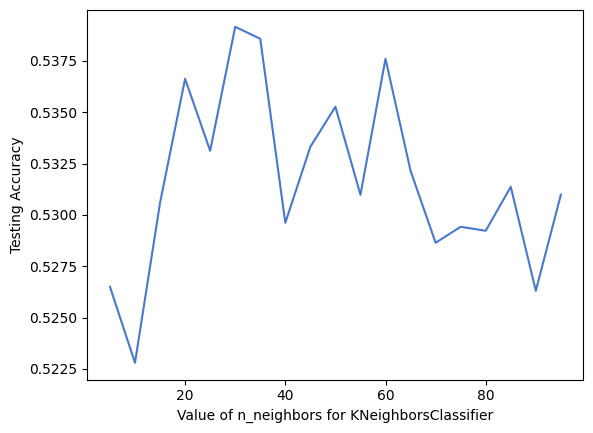

In [ ]:
scores =[]
for k in range(5, 100,5):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(range(5, 100 ,5), scores)
plt.xlabel('Value of n_neighbors for KNeighborsClassifier')
plt.ylabel('Testing Accuracy')

In [ ]:
grid_params = { 'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan'],
                'n_neighbors' : [15,20,25,30,35,40]}
knn = KNeighborsClassifier(n_neighbors = 5)
CV_knn = GridSearchCV(estimator=knn, param_grid=grid_params, cv= 5)
CV_knn.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': [15, 20, 25, 30, 35, 40],
                         'weights': ['uniform', 'distance']})

In [ ]:
CV_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 40, 'weights': 'uniform'}

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 40, metric = 'manhattan', weights='uniform')
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred,output_dict=True)
print("Accuracy test:", accuracy)
print("Classification report", report)
model_results_df=addReportDf(model_results_df,report, "KNN")

Accuracy test: 0.5436477007014809
Classification report {'0': {'precision': 0.5270796460176991, 'recall': 0.6387816387816387, 'f1-score': 0.5775795190069821, 'support': 2331}, '1': {'precision': 0.563935847420893, 'recall': 0.5400581154005811, 'f1-score': 0.5517387616624259, 'support': 2409}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 392}, 'accuracy': 0.5436477007014809, 'macro avg': {'precision': 0.36367183114619733, 'recall': 0.39294658472740657, 'f1-score': 0.37643942688980264, 'support': 5132}, 'weighted avg': {'precision': 0.5041200528651963, 'recall': 0.5436477007014809, 'f1-score': 0.5213321386691464, 'support': 5132}}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0, 0.5, 'Testing Accuracy')

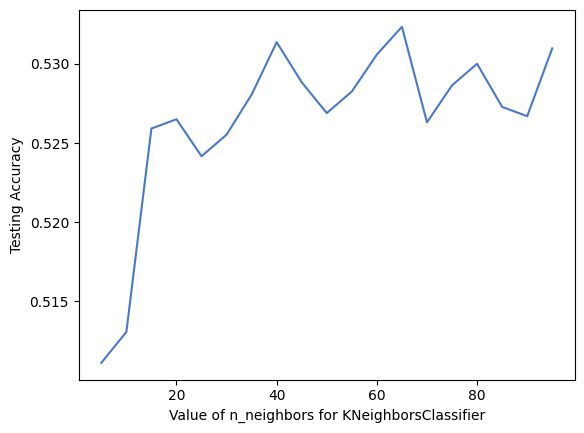

In [ ]:
scores =[]
for k in range(5, 100,5):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x_train_pca, y_train)
    y_pred = knn.predict(x_test_pca)
    scores.append(accuracy_score(y_test, y_pred))

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(range(5, 100 ,5), scores)
plt.xlabel('Value of n_neighbors for KNeighborsClassifier')
plt.ylabel('Testing Accuracy')

In [ ]:
grid_params = { 'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan'],
                'n_neighbors' : [50,55,60,65,70,75]}
knn = KNeighborsClassifier(n_neighbors = 5)
CV_knn = GridSearchCV(estimator=knn, param_grid=grid_params, cv= 5)
CV_knn.fit(x_train_pca, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': [50, 55, 60, 65, 70, 75],
                         'weights': ['uniform', 'distance']})

In [ ]:
CV_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 50, 'weights': 'distance'}

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 50, metric = 'manhattan', weights='distance')
knn.fit(x_train_pca, y_train)
y_pred = knn.predict(x_test_pca)
accuracy = accuracy_score(y_test, y_pred)
pca_report = classification_report(y_test, y_pred,output_dict=True)
print("Accuracy test:", accuracy)
print("Classification report", pca_report)
model_results_df=addReportDf(model_results_df,pca_report, "PCA KNN")

Accuracy test: 0.5251363990646921
Classification report {'0': {'precision': 0.5123134328358209, 'recall': 0.589017589017589, 'f1-score': 0.5479944122929555, 'support': 2331}, '1': {'precision': 0.5434335117332235, 'recall': 0.547945205479452, 'f1-score': 0.5456800330715171, 'support': 2409}, '2': {'precision': 0.08695652173913043, 'recall': 0.00510204081632653, 'f1-score': 0.009638554216867469, 'support': 392}, 'accuracy': 0.5251363990646921, 'macro avg': {'precision': 0.38090115543605824, 'recall': 0.3806882784377892, 'f1-score': 0.36777099986044676, 'support': 5132}, 'weighted avg': {'precision': 0.4944311960692465, 'recall': 0.5251363990646921, 'f1-score': 0.5057865331210398, 'support': 5132}}


In [ ]:
grid_params = { 'kernel' : ['linear','poly','sigmoid',]}
svc = SVC(random_state=42)
CV_svc = GridSearchCV(estimator=svc, param_grid=grid_params, cv= 5)
CV_svc.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'kernel': ['linear', 'poly', 'sigmoid']})

In [ ]:
CV_svc.best_params_

{'kernel': 'poly'}

In [ ]:
svc = SVC(random_state=42,kernel='poly')
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred,output_dict=True)
print("Accuracy test:", accuracy)
print("Classification report", report)
#model_results_df=addReportDf(model_results_df,report,"SVC")

Accuracy test: 0.548908807482463
Classification report {'0': {'precision': 0.5273224043715847, 'recall': 0.6623766623766624, 'f1-score': 0.5871838752614565, 'support': 2331}, '1': {'precision': 0.5775862068965517, 'recall': 0.5284350352843503, 'f1-score': 0.5519184912204638, 'support': 2409}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 392}, 'accuracy': 0.548908807482463, 'macro avg': {'precision': 0.3683028704227122, 'recall': 0.39693723255367086, 'f1-score': 0.37970078882730673, 'support': 5132}, 'weighted avg': {'precision': 0.5106378988706074, 'recall': 0.548908807482463, 'f1-score': 0.5257788890460937, 'support': 5132}}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


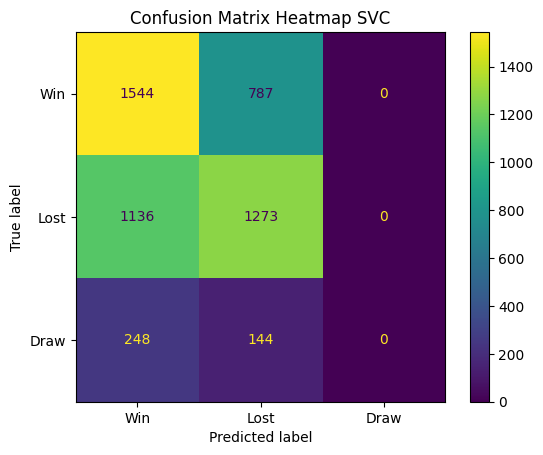

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=svc.classes_)

# Rename the labels
display_labels = ['Win', 'Lost', 'Draw']

# Plot the confusion matrix heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap='viridis')

# Add title
plt.title('Confusion Matrix Heatmap SVC')

plt.show()

In [ ]:
grid_params = { 'kernel' : ['linear','poly','sigmoid',]}
svc = SVC(random_state=42)
CV_svc = GridSearchCV(estimator=svc, param_grid=grid_params, cv= 5)
CV_svc.fit(x_train_pca, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'kernel': ['linear', 'poly', 'sigmoid']})

In [ ]:
CV_svc.best_params_

{'kernel': 'poly'}

In [ ]:
svc = SVC(random_state=42,kernel='poly')
svc.fit(x_train_pca, y_train)
y_pred = svc.predict(x_test_pca)
accuracy = accuracy_score(y_test, y_pred)
pca_report = classification_report(y_test, y_pred,output_dict=True)
print("Accuracy test:", accuracy)
print("Classification report", pca_report)
model_results_df=addReportDf(model_results_df,pca_report,"PCA SVC")

Accuracy test: 0.5261106780982073
Classification report {'0': {'precision': 0.5004349086691795, 'recall': 0.7404547404547405, 'f1-score': 0.5972318339100345, 'support': 2331}, '1': {'precision': 0.5794170136823319, 'recall': 0.40431714404317143, 'f1-score': 0.47628361858190704, 'support': 2409}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 392}, 'accuracy': 0.5261106780982073, 'macro avg': {'precision': 0.3599506407838371, 'recall': 0.3815906281659706, 'f1-score': 0.35783848416398056, 'support': 5132}, 'weighted avg': {'precision': 0.49928475410533807, 'recall': 0.5261106780982073, 'f1-score': 0.49483917420267043, 'support': 5132}}


In [ ]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
y_pred = mnb.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred,output_dict=True)
print("Accuracy test:", accuracy)
print("Classification report", report)
model_results_df=addReportDf(model_results_df,report, "Multinomial Naive Bayes")

Accuracy test: 0.5085736554949337
Classification report {'0': {'precision': 0.49130434782608695, 'recall': 0.6786786786786787, 'f1-score': 0.5699873896595208, 'support': 2331}, '1': {'precision': 0.5376569037656904, 'recall': 0.42673308426733086, 'f1-score': 0.4758157833834761, 'support': 2409}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 392}, 'accuracy': 0.5085736554949337, 'macro avg': {'precision': 0.3429870838639258, 'recall': 0.36847058764866986, 'f1-score': 0.34860105768099897, 'support': 5132}, 'weighted avg': {'precision': 0.47553505766838594, 'recall': 0.5085736554949337, 'f1-score': 0.4822449001299955, 'support': 5132}}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mnb = MultinomialNB()
mnb.fit(x_train_pca, y_train)
y_pred = mnb.predict(x_test_pca)
accuracy = accuracy_score(y_test, y_pred)
pca_report = classification_report(y_test, y_pred,output_dict=True)
print("Accuracy test:", accuracy)
print("Classification report", pca_report)
model_results_df=addReportDf(model_results_df,pca_report, "PCA Multinomial Naive Bayes")

Accuracy test: 0.4719407638347623
Classification report {'0': {'precision': 0.46296296296296297, 'recall': 0.975975975975976, 'f1-score': 0.6280193236714976, 'support': 2331}, '1': {'precision': 0.6743119266055045, 'recall': 0.06102117061021171, 'f1-score': 0.11191473163304148, 'support': 2409}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 392}, 'accuracy': 0.4719407638347623, 'macro avg': {'precision': 0.3790916298561558, 'recall': 0.3456657155287292, 'f1-score': 0.24664468510151302, 'support': 5132}, 'weighted avg': {'precision': 0.5268090603778891, 'recall': 0.4719407638347623, 'f1-score': 0.33778558690223265, 'support': 5132}}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
display(model_results_df)

,precision,recall,f1,model_name,avg_score
0,0.425988,0.425893,0.425930,Random,0.425937
1,0.499994,0.520460,0.508473,Random Forest,0.509642
2,0.499994,0.520460,0.508473,PCA Random Forest,0.509642
3,0.504120,0.543648,0.521332,KNN,0.523033
4,0.494431,0.525136,0.505787,PCA KNN,0.508451
5,0.510638,0.548909,0.525779,SVC,0.528442
6,0.499285,0.526111,0.494839,PCA SVC,0.506745
7,0.475535,0.508574,0.482245,Multinomial Naive Bayes,0.488785
8,0.526809,0.471941,0.337786,PCA Multinomial Naive Bayes,0.445512
10,0.529534,0.554754,0.533000,GradientBoostingClassifier,0.539096


<ipython-input-143-e48a4c5bd7a3>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')


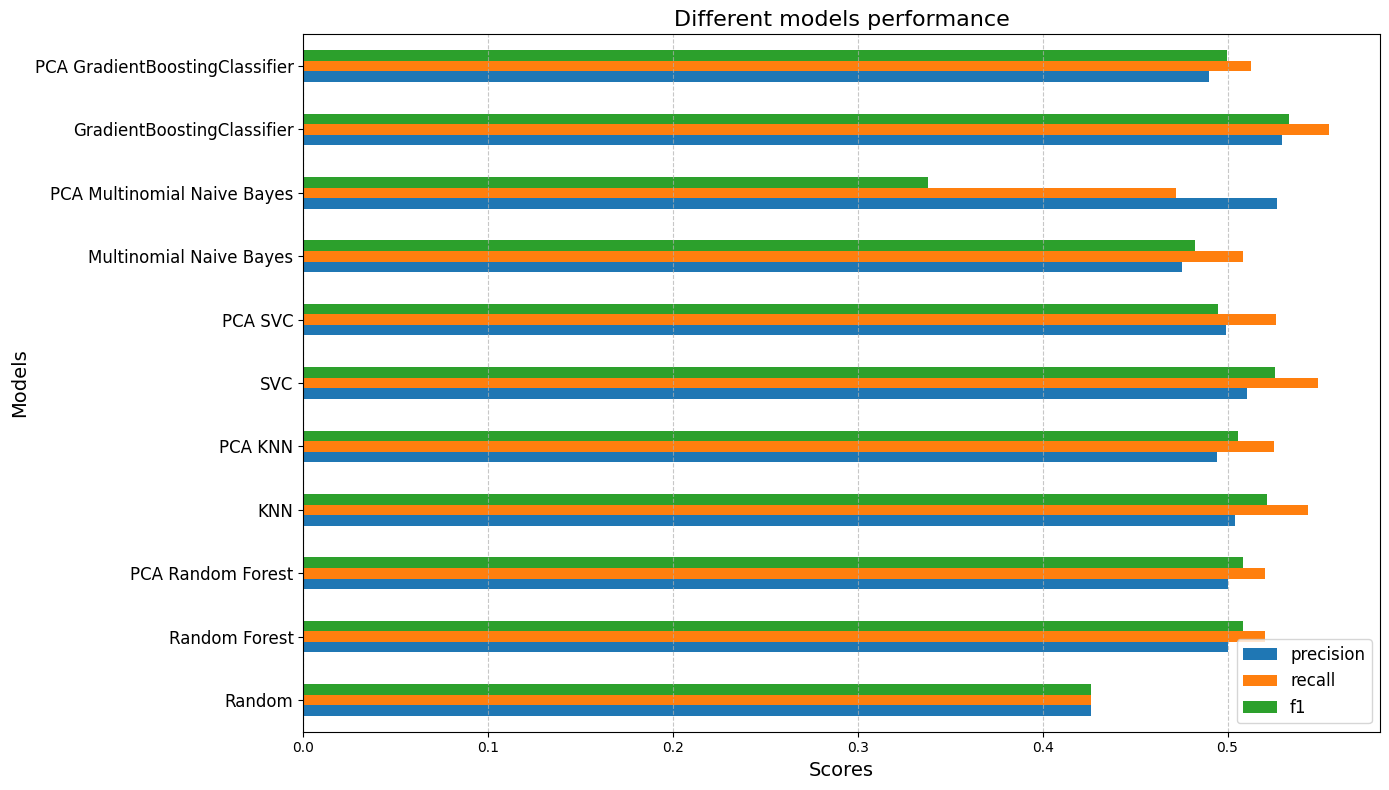

In [ ]:
# Set the style
plt.style.use('seaborn-muted')

fig, ax = plt.subplots(figsize=(14, 8))

# Create a new bar chart with custom colors
colors = plt.cm.tab10.colors[:len(model_results_df.columns)]
model_results_df.plot.barh(ax=ax, color=colors)

# Set the y tick labels
ax.set_yticklabels(model_results_df['model_name'], fontsize=12)

# Set the y axis label
ax.set_ylabel('Models', fontsize=14)

# Set the chart's title
ax.set_title('Different models performance', fontsize=16)

# Set the x axis label
ax.set_xlabel("Scores", fontsize=14)


# Add grid lines
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Add legend
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()


<ipython-input-170-2a443c6649fb>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='precision', y='model_name', data=df_precision_sorted, palette='viridis')


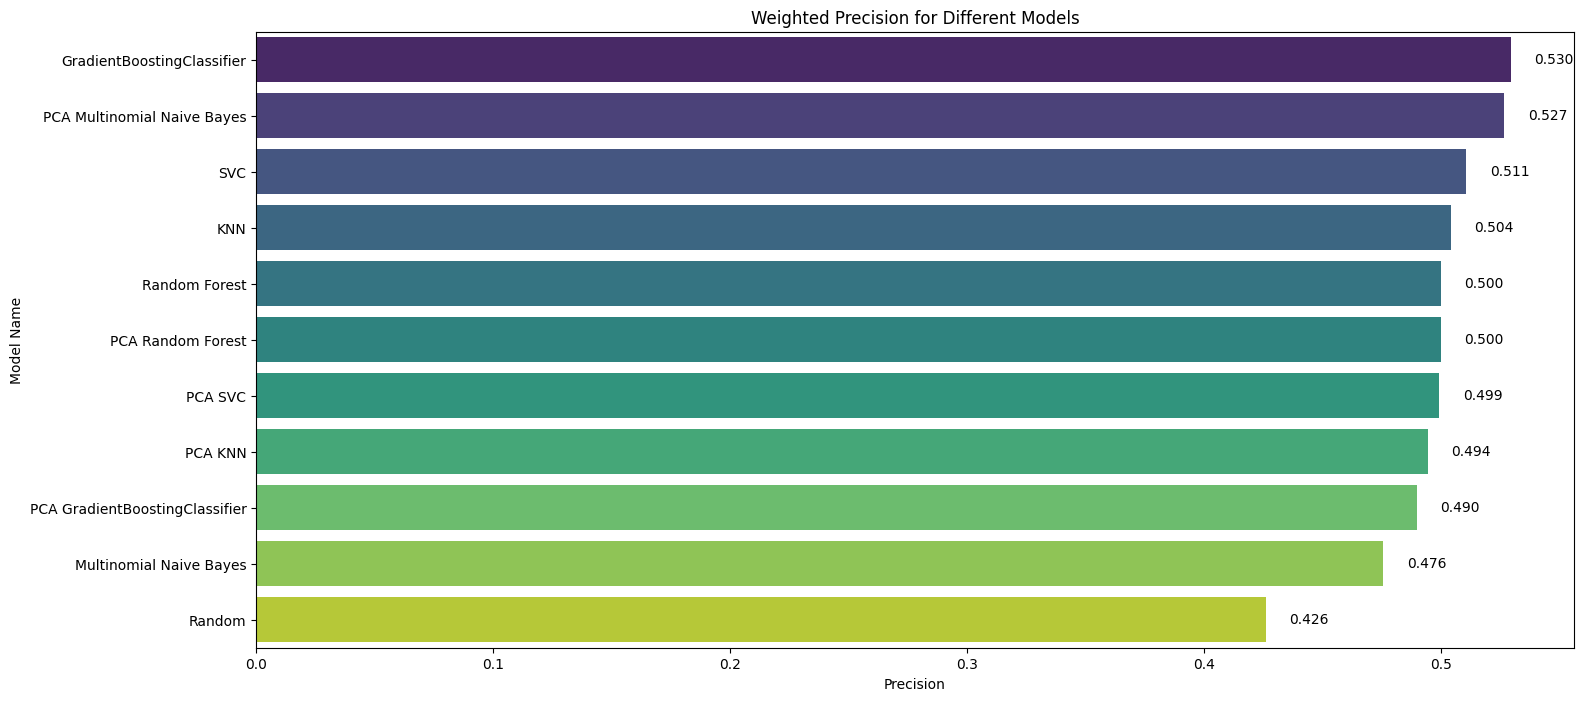

<ipython-input-170-2a443c6649fb>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='recall', y='model_name', data=df_recall_sorted, palette='viridis')


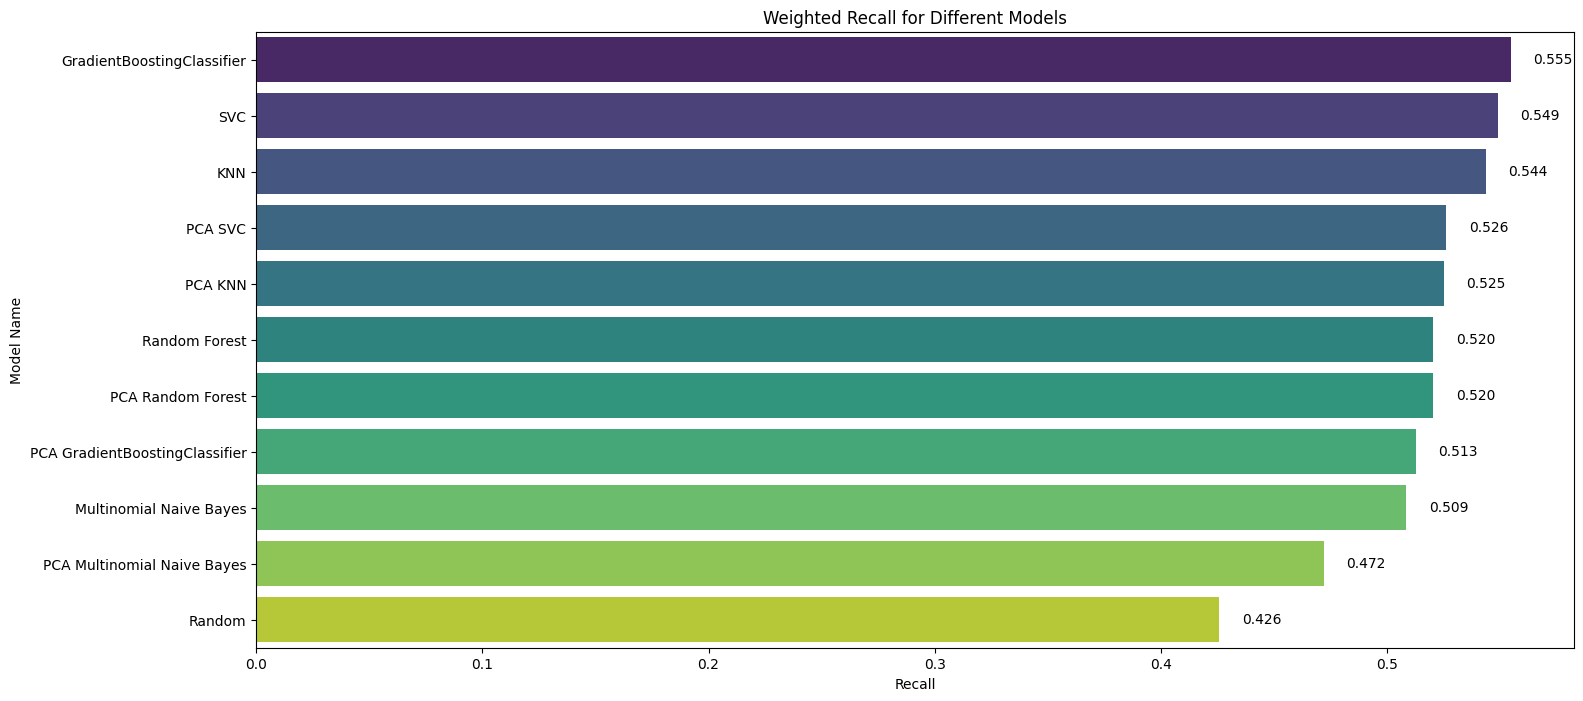

<ipython-input-170-2a443c6649fb>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='f1', y='model_name', data=df_f1_sorted, palette='viridis')


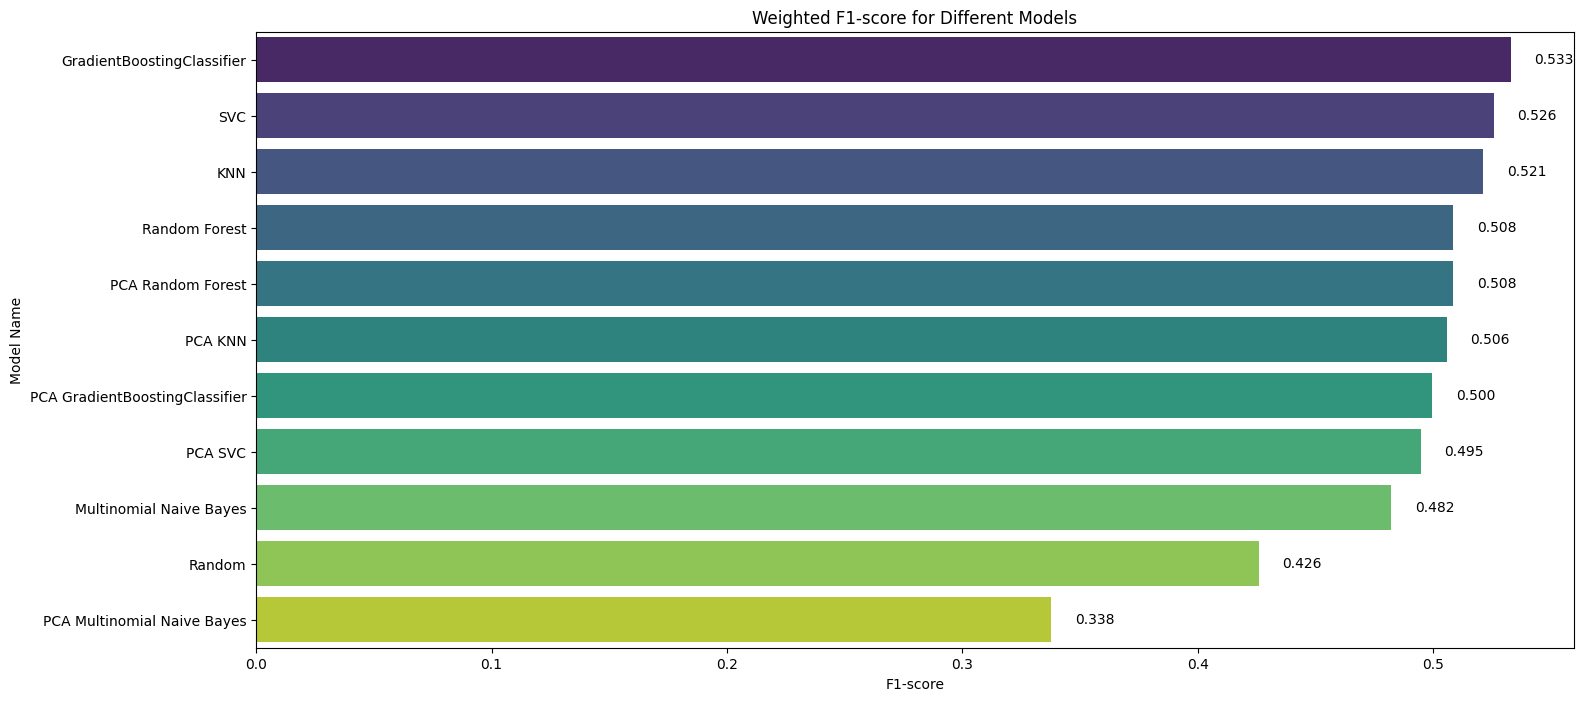

In [ ]:
# Create three separate DataFrames sorted by precision, recall, and F1-score
df_precision_sorted = model_results_df.sort_values(by='precision', ascending=False)
df_recall_sorted = model_results_df.sort_values(by='recall', ascending=False)
df_f1_sorted = model_results_df.sort_values(by='f1', ascending=False)

# Plot precision for each model
plt.figure(figsize=(17, 8))
ax = sns.barplot(x='precision', y='model_name', data=df_precision_sorted, palette='viridis')
plt.xlabel('Precision')
plt.ylabel('Model Name')
plt.title('Weighted Precision for Different Models')

# Add value labels for precision
for i, (prec, model) in enumerate(zip(df_precision_sorted['precision'], df_precision_sorted['model_name'])):
    ax.text(prec + 0.01, i, f'{prec:.3f}', va='center', color='black')

plt.show()

# Plot recall for each model
plt.figure(figsize=(17, 8))
ax = sns.barplot(x='recall', y='model_name', data=df_recall_sorted, palette='viridis')
plt.xlabel('Recall')
plt.ylabel('Model Name')
plt.title('Weighted Recall for Different Models')

# Add value labels for recall
for i, (rec, model) in enumerate(zip(df_recall_sorted['recall'], df_recall_sorted['model_name'])):
    ax.text(rec + 0.01, i, f'{rec:.3f}', va='center', color='black')

plt.show()

# Plot F1-score for each model
plt.figure(figsize=(17, 8))
ax = sns.barplot(x='f1', y='model_name', data=df_f1_sorted, palette='viridis')
plt.xlabel('F1-score')
plt.ylabel('Model Name')
plt.title('Weighted F1-score for Different Models')

# Add value labels for F1-score
for i, (f1, model) in enumerate(zip(df_f1_sorted['f1'], df_f1_sorted['model_name'])):
    ax.text(f1 + 0.01, i, f'{f1:.3f}', va='center', color='black')

plt.show()